In [47]:
import json

labels_file = "labels.json"
with open(labels_file) as f:
    classes = json.load(f)
print(classes)

['--bg--', 'landmine', 'nomine']


In [48]:
import onnxruntime
try:
    session = onnxruntime.InferenceSession("model.onnx")
    print("ONNX model loaded...")
except Exception as e: 
    print("Error loading ONNX file: ", str(e))

ONNX model loaded...


In [49]:
sess_input = session.get_inputs()
sess_output = session.get_outputs()
print(f"No. of inputs : {len(sess_input)}, No. of outputs : {len(sess_output)}")

for idx, input_ in enumerate(range(len(sess_input))):
    input_name = sess_input[input_].name
    input_shape = sess_input[input_].shape
    input_type = sess_input[input_].type
    print(f"{idx} Input name : { input_name }, Input shape : {input_shape}, \
    Input type  : {input_type}")  

for idx, output in enumerate(range(len(sess_output))):
    output_name = sess_output[output].name
    output_shape = sess_output[output].shape
    output_type = sess_output[output].type
    print(f" {idx} Output name : {output_name}, Output shape : {output_shape}, \
    Output type  : {output_type}")

No. of inputs : 1, No. of outputs : 3
0 Input name : input, Input shape : ['batch', 3, 600, 800],     Input type  : tensor(float)
 0 Output name : boxes, Output shape : ['prediction', 4],     Output type  : tensor(float)
 1 Output name : labels, Output shape : ['prediction'],     Output type  : tensor(int64)
 2 Output name : scores, Output shape : ['prediction'],     Output type  : tensor(float)


In [50]:
batch, channel, height_onnx, width_onnx = session.get_inputs()[0].shape
batch, channel, height_onnx, width_onnx

('batch', 3, 600, 800)

In [51]:
import glob
import numpy as np
from PIL import Image

def preprocess(image, height_onnx, width_onnx):
    """Perform pre-processing on raw input image
    
    :param image: raw input image
    :type image: PIL image
    :param height_onnx: expected height of an input image in onnx model
    :type height_onnx: Int
    :param width_onnx: expected width of an input image in onnx model
    :type width_onnx: Int
    :return: pre-processed image in numpy format
    :rtype: ndarray 1xCxHxW
    """

    image = image.convert('RGB')
    image = image.resize((width_onnx, height_onnx))
    np_image = np.array(image)
    # HWC -> CHW
    np_image = np_image.transpose(2, 0, 1) # CxHxW
    # normalize the image
    mean_vec = np.array([0.485, 0.456, 0.406])
    std_vec = np.array([0.229, 0.224, 0.225])
    norm_img_data = np.zeros(np_image.shape).astype('float32')
    for i in range(np_image.shape[0]):
        norm_img_data[i,:,:] = (np_image[i,:,:] / 255 - mean_vec[i]) / std_vec[i]
    np_image = np.expand_dims(norm_img_data, axis=0) # 1xCxHxW
    return np_image

# following code loads only batch_size number of images for demonstrating ONNX inference
# make sure that the data directory has at least batch_size number of images

batch_size = 1
test_images_path = "newdataset2/IMG_2078.JPG" # replace with path to images
image_files = glob.glob(test_images_path)
img_processed_list = []
for i in range(batch_size):
    img = Image.open(image_files[i])
    img_processed_list.append(preprocess(img, height_onnx, width_onnx))
    
if len(img_processed_list) > 1:
    img_data = np.concatenate(img_processed_list)
elif len(img_processed_list) == 1:
    img_data = img_processed_list[0]
else:
    img_data = None

print(img_data.shape[0])

assert batch_size == img_data.shape[0]

1


In [52]:
print(img_data.shape[0])

1


In [53]:
def get_predictions_from_ONNX(onnx_session, img_data):
    """perform predictions with ONNX runtime
    
    :param onnx_session: onnx model session
    :type onnx_session: class InferenceSession
    :param img_data: pre-processed numpy image
    :type img_data: ndarray with shape 1xCxHxW
    :return: boxes, labels , scores 
            (No. of boxes, 4) (No. of boxes,) (No. of boxes,)
    :rtype: tuple
    """

    sess_input = onnx_session.get_inputs()
    sess_output = onnx_session.get_outputs()
    
    # predict with ONNX Runtime
    output_names = [output.name for output in sess_output]
    predictions = onnx_session.run(output_names=output_names,\
                                               input_feed={sess_input[0].name: img_data})

    return output_names, predictions

output_names, predictions = get_predictions_from_ONNX(session, img_data)

In [54]:
def _get_box_dims(image_shape, box):
    box_keys = ['topX', 'topY', 'bottomX', 'bottomY']
    height, width = image_shape[0], image_shape[1]

    box_dims = dict(zip(box_keys, [coordinate.item() for coordinate in box]))

    box_dims['topX'] = box_dims['topX'] * 1.0 / width
    box_dims['bottomX'] = box_dims['bottomX'] * 1.0 / width
    box_dims['topY'] = box_dims['topY'] * 1.0 / height
    box_dims['bottomY'] = box_dims['bottomY'] * 1.0 / height

    return box_dims

def _get_prediction(boxes, labels, scores, image_shape, classes):
    bounding_boxes = []
    for box, label_index, score in zip(boxes, labels, scores):
        box_dims = _get_box_dims(image_shape, box)

        box_record = {'box': box_dims,
                      'label': classes[label_index],
                      'score': score.item()}

        bounding_boxes.append(box_record)

    return bounding_boxes

# Filter the results with threshold.
# Please replace the threshold for your test scenario.
score_threshold = 0.8
filtered_boxes_batch = []
for batch_sample in range(0, batch_size*3, 3):
    # in case of retinanet change the order of boxes, labels, scores to boxes, scores, labels
    # confirm the same from order of boxes, labels, scores output_names 
    boxes, labels, scores = predictions[batch_sample], predictions[batch_sample + 1], predictions[batch_sample + 2]
    bounding_boxes = _get_prediction(boxes, labels, scores, (height_onnx, width_onnx), classes)
    filtered_bounding_boxes = [box for box in bounding_boxes if box['score'] >= score_threshold]
    filtered_boxes_batch.append(filtered_bounding_boxes)

(5184, 3456)


<Figure size 1800x1200 with 0 Axes>

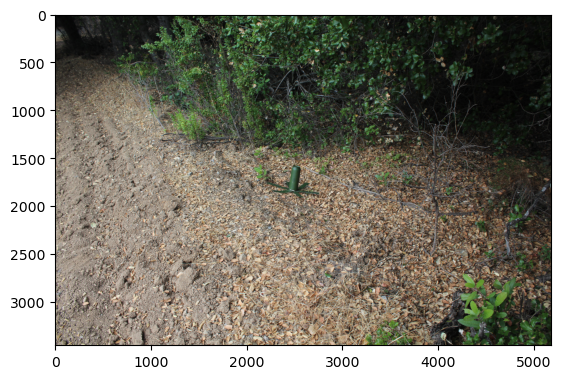

In [55]:
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.pyplot as plt
%matplotlib inline

img_np = mpimg.imread(image_files[0])  # replace with desired image index
image_boxes = filtered_boxes_batch[0]  # replace with desired image index

IMAGE_SIZE = (18, 12)
plt.figure(figsize=IMAGE_SIZE)
img = Image.fromarray(img_np.astype('uint8'), 'RGB')
x, y = img.size
print(img.size)

fig,ax = plt.subplots(1)
# Display the image
ax.imshow(img_np)

# Draw box and label for each detection 
for detect in image_boxes:
    label = detect['label']
    box = detect['box']
    ymin, xmin, ymax, xmax =  box['topY'], box['topX'], box['bottomY'], box['bottomX']
    topleft_x, topleft_y = x * xmin, y * ymin
    width, height = x * (xmax - xmin), y * (ymax - ymin)
    print('{}: {}, {}, {}, {}'.format(detect['label'], topleft_x, topleft_y, width, height))
    rect = patches.Rectangle((topleft_x, topleft_y), width, height, 
                             linewidth=1, edgecolor='green', facecolor='none')

    ax.add_patch(rect)
    color = 'green'
    plt.text(topleft_x, topleft_y, label, color=color)

plt.show()